Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from tqdm import tqdm
import time

define data path

In [4]:
data_path = r'D:\OneDrive - CUHK-Shenzhen\STAT4012\Face_Detection\data_bw'

Loading the Data

In [5]:
class_names = ['Arjun_Rampal', 'Arshad_Warsi', 'Asin', 'Ayushmann_Khurrana', 'Bhumi_Pednekar', 'Bipasha_Basu', 'Bobby_Deol', 'Deepika_Padukone', 'Disha_Patani', 'Emraan_Hashmi', 'Esha_Gupta', 'Farhan_Akhtar', 'Govinda']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
from sklearn.preprocessing import LabelBinarizer 
encoder = LabelBinarizer()
data_class_1hot = encoder.fit_transform(train_lab)
data_class_1hot #这里返回的就是一个2D的ndarray，而不是一个sparse matrix

In [6]:
os.path.join(data_path,'train')

'D:\\OneDrive - CUHK-Shenzhen\\STAT4012\\Face_Detection\\data_bw\\train'

In [14]:
def load_data():
    datasets= [os.path.join(data_path,'train'), os.path.join(data_path,'val')]
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                try:
                    # Get the path name of the image
                    img_path = os.path.join(os.path.join(dataset, folder), file)
                    
                    # Open and resize the img
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE) 
                    
                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
                except:
                    continue
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [15]:
datasets= [os.path.join(data_path,'train'), os.path.join(data_path,'val')]
datasets

['D:\\OneDrive - CUHK-Shenzhen\\STAT4012\\Face_Detection\\data_bw\\train',
 'D:\\OneDrive - CUHK-Shenzhen\\STAT4012\\Face_Detection\\data_bw\\val']

In [53]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading D:\OneDrive - CUHK-Shenzhen\STAT4012\Face_Detection\data_bw\train


100%|██████████| 56/56 [00:00<00:00, 152.97it/s]


Loading D:\OneDrive - CUHK-Shenzhen\STAT4012\Face_Detection\data_bw\val


100%|██████████| 24/24 [00:00<00:00, 174.16it/s]


In [54]:
train_img, train_lab = shuffle(train_images, train_labels, random_state=4012)

Looking to the detail of the dataset

In [55]:
n_train = train_lab.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1058
Number of testing examples: 451
Each image is of size: (150, 150)


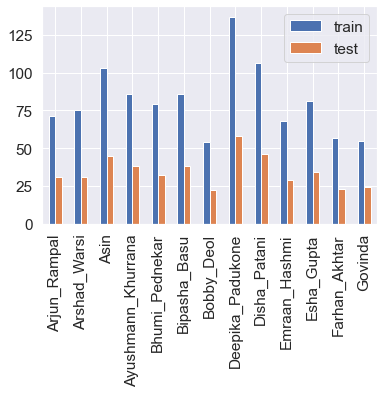

In [56]:
import pandas as pd

_, train_counts = np.unique(train_lab, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [57]:
train_img = train_img / 255.0 
test_img = test_images / 255.0

In [58]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

Show random images from the dataset

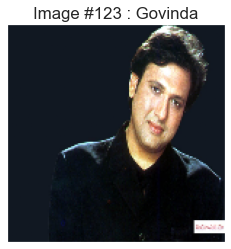

In [62]:
display_random_image(class_names, train_img, train_lab)

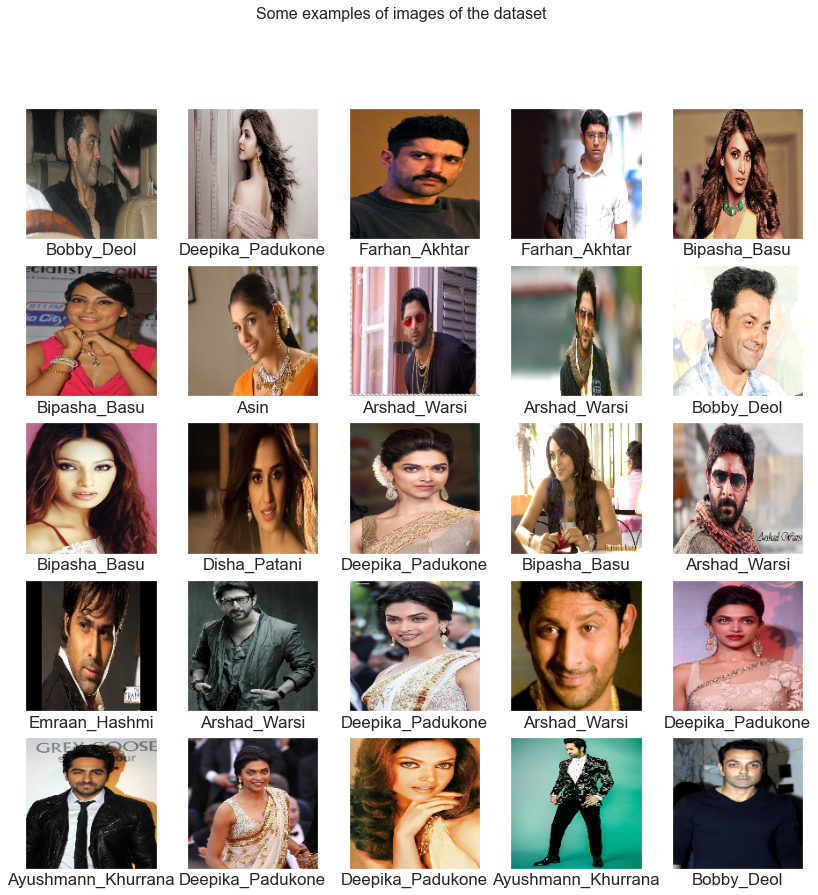

In [63]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(14,14))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_img, train_lab)

configure the hyperparameters of the model

In [64]:
train_lab

array([ 6,  7, 11, ...,  4,  9,  3])

In [65]:
train_img

array([[[[0.07058824, 0.07058824, 0.07058824],
         [0.05882353, 0.05882353, 0.06666667],
         [0.05882353, 0.0627451 , 0.07058824],
         ...,
         [0.69411767, 0.6745098 , 0.54901963],
         [0.6901961 , 0.65882355, 0.54901963],
         [0.70980394, 0.6862745 , 0.5647059 ]],

        [[0.14509805, 0.14117648, 0.12941177],
         [0.10588235, 0.10588235, 0.09019608],
         [0.09019608, 0.09411765, 0.07843138],
         ...,
         [0.59607846, 0.5764706 , 0.49411765],
         [0.6156863 , 0.6       , 0.49803922],
         [0.6313726 , 0.6156863 , 0.5058824 ]],

        [[0.23529412, 0.21960784, 0.19607843],
         [0.21568628, 0.20392157, 0.18039216],
         [0.19607843, 0.19607843, 0.16078432],
         ...,
         [0.44705883, 0.43137255, 0.38039216],
         [0.47058824, 0.45882353, 0.4       ],
         [0.49411765, 0.4862745 , 0.40784314]],

        ...,

        [[0.90588236, 0.9098039 , 0.8901961 ],
         [0.9098039 , 0.90588236, 0.8901961 ]

In [113]:
# one-hot encoding，独热编码
from sklearn.preprocessing import OneHotEncoder 
# 需要在前面encode的基础上做one-hot
# 但是注意fit_transform()用于2D-ndarray，而data_class_encoded是一个1D数组，因此需要用reshape进行大小的重塑
print(train_lab.shape) #一个list没有shape的第二维度
print(train_lab.reshape(-1, 1).shape) #变成列向量，二维数组
encoder = OneHotEncoder()
data_class_1hot = encoder.fit_transform(train_lab.reshape(-1,1))
data_class_1hot 
# 得到的是一个sparse matrix，还需要转换。可以理解，因为one-hot encoding本来得到的就是矩阵，而且由于是1,0矩阵，里面有大量的元素是0，所以使用sparse matrix储存，相当于一个2D-array
# 如果想可以把2D的sparse array转成的密集2D的ndarray
data_class_1hot.toarray()

(1058,)
(1058, 1)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
data_class_1hot.toarray()[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [115]:
tf.random.set_seed(0)

#MLP
model = Sequential()

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(13,activation="softmax"))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
start_time = time.time()
history = model.fit(train_img, data_class_1hot.toarray(), batch_size=32, epochs=100, validation_split = 0.3)
end_time = time.time()
train_time = end_time - start_time


Epoch 1/100
6/6 [==============================] - 2s 126ms/step - loss: 0.8041 - accuracy: 0.0973 - val_loss: 0.7805 - val_accuracy: 0.1038
Epoch 2/100
6/6 [==============================] - 0s 53ms/step - loss: 0.7355 - accuracy: 0.1432 - val_loss: 0.7229 - val_accuracy: 0.0660
Epoch 3/100
6/6 [==============================] - 0s 53ms/step - loss: 0.6972 - accuracy: 0.2378 - val_loss: 0.6862 - val_accuracy: 0.0566
Epoch 4/100
6/6 [==============================] - 0s 51ms/step - loss: 0.6756 - accuracy: 0.2919 - val_loss: 0.6850 - val_accuracy: 0.0535
Epoch 5/100
6/6 [==============================] - 0s 49ms/step - loss: 0.6594 - accuracy: 0.3622 - val_loss: 0.6831 - val_accuracy: 0.0629
Epoch 6/100
6/6 [==============================] - 0s 53ms/step - loss: 0.6464 - accuracy: 0.4189 - val_loss: 0.6801 - val_accuracy: 0.0597
Epoch 7/100
6/6 [==============================] - 0s 64ms/step - loss: 0.6343 - accuracy: 0.4811 - val_loss: 0.6840 - val_accuracy: 0.0629
Epoch 8/100
6/6 [==

In [77]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 67500)             0         
                                                                 
 dense_70 (Dense)            (None, 64)                4320064   
                                                                 
 batch_normalization_60 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_61 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_72 (Dense)            (None, 256)             

In [82]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

Plot the accuracy and loss of between training set and the validation set

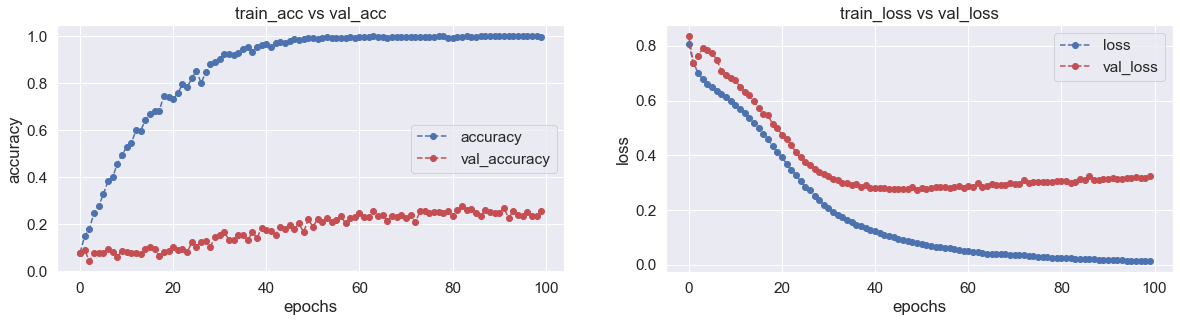

In [83]:
plot_accuracy_loss(history)

show the accuracy of the model

In [116]:
# one-hot encoding，独热编码
from sklearn.preprocessing import OneHotEncoder 
# 需要在前面encode的基础上做one-hot
# 但是注意fit_transform()用于2D-ndarray，而data_class_encoded是一个1D数组，因此需要用reshape进行大小的重塑
print(test_labels.shape) #一个list没有shape的第二维度
print(test_labels.reshape(-1, 1).shape) #变成列向量，二维数组
encoder = OneHotEncoder()
data_class_1hot = encoder.fit_transform(test_labels.reshape(-1,1))
data_class_1hot 
# 得到的是一个sparse matrix，还需要转换。可以理解，因为one-hot encoding本来得到的就是矩阵，而且由于是1,0矩阵，里面有大量的元素是0，所以使用sparse matrix储存，相当于一个2D-array
# 如果想可以把2D的sparse array转成的密集2D的ndarray
data_class_1hot.toarray()

(451,)
(451, 1)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [117]:
test_loss = model.evaluate(test_img, data_class_1hot.toarray())

15/15 [==============================] - 0s 7ms/step - loss: 0.3368 - accuracy: 0.2084


In [93]:
pred_labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

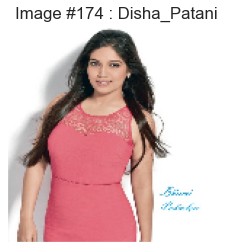

In [147]:
def display_random_image2(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

predictions = np.round(model.predict(test_img)).astype(int)    # Vector of probabilities
pred_labels = np.squeeze(predictions) 
pred = np.array([i.argmax() for i in pred_labels])
display_random_image2(class_names, test_img, pred)

Print the mislabeled images 

In [149]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

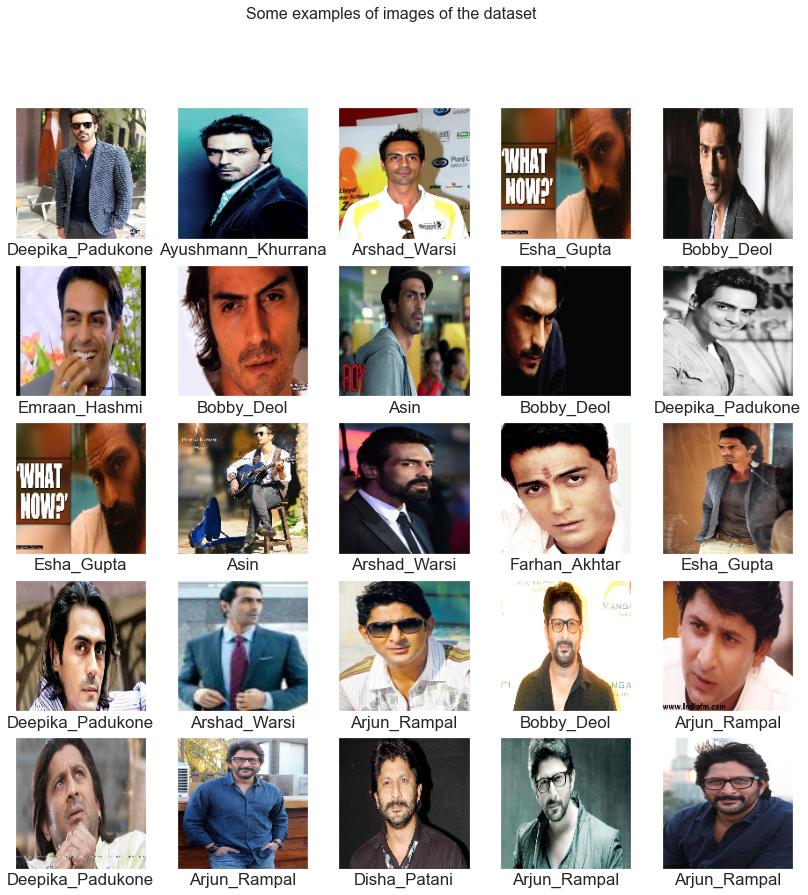

In [150]:
print_mislabeled_images(class_names, test_img, test_labels, pred)

In [151]:
CM = confusion_matrix(test_labels, pred)

print the confusion matrix

In [152]:
CM

array([[14,  3,  2,  1,  0,  0,  3,  3,  0,  1,  3,  1,  0],
       [17,  5,  1,  1,  0,  0,  2,  2,  1,  0,  1,  1,  0],
       [11,  1, 12,  0,  0,  3,  0,  7,  2,  0,  5,  2,  2],
       [16,  0,  2, 10,  1,  0,  0,  3,  2,  0,  1,  2,  1],
       [13,  0,  1,  1,  6,  0,  0,  5,  4,  0,  2,  0,  0],
       [19,  0,  7,  0,  0,  4,  0,  3,  0,  1,  4,  0,  0],
       [12,  3,  1,  1,  1,  0,  0,  0,  0,  0,  1,  2,  1],
       [31,  1,  4,  0,  1,  2,  1, 14,  2,  0,  0,  0,  2],
       [15,  2,  9,  2,  0,  0,  2,  3, 10,  0,  0,  2,  1],
       [13,  2,  1,  3,  0,  0,  2,  2,  3,  2,  1,  0,  0],
       [15,  1,  2,  1,  0,  4,  1,  3,  1,  0,  6,  0,  0],
       [12,  2,  0,  2,  0,  0,  1,  2,  1,  0,  1,  0,  2],
       [11,  0,  2,  1,  0,  1,  2,  3,  1,  0,  1,  0,  2]], dtype=int64)

print the training time

In [153]:
print(train_time)

29.899991273880005
